In [ ]:
# 1) narrow down key column candidates with the supervised approach
# 2) test them with the unsupervised approach to identify the best one

In [14]:
import os
import re
import glob
import time
import random 
import pickle
import signal
import statistics
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample
from datetime import datetime
from itertools import product
from collections import Counter
from SetSimilaritySearch import all_pairs
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
# for CV
# process mining
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
# miners
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
# performance metrics
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

In [1]:
def load_event_log(dataset_path=None, n_rows=1000):
    try:
        event_log = pd.read_csv(dataset_path, nrows=n_rows)
    except:
        return None
    h = event_log.columns.values.tolist()
    # check if a dataset contains a tuple of case_id, activity, and timestamp
    if ('case:concept:name' in h) and ('concept:name' in h) and ('time:timestamp' in h):
        print(dataset_path, 'is valid for evaluation')
        # replace NaN with ''
        event_log = event_log.fillna(np.nan).replace([np.nan], [''])
        return event_log
    else:
        return None

In [4]:
# feature_extraction: 
# input: values in a column
# output: features
def feature_extraction(values, round_digits=3):
    def local_feature_extraction(value):
        patterns = ['[a-z]', '[A-Z]', '\d', '\s', '[^a-zA-Z\d\s]']
        f = {}
        if len(value) == 0:
            f['f_chars'] = 0 
            f['f_words'] = 0
            for p in patterns:
                f['f_{}'.format(p)] = 0
        else:
            # length: length of a value
            f['f_chars'] = len(value)
            # words: number of words in a value
            f['f_words'] = len(re.findall(r'\w+', value))
            # The following code find the frequency of each pattern in patterns in a value
            for p in patterns:
                f['f_{}'.format(p)] = round(len(re.findall(p, value)) / len(value), round_digits)
        return f

    # set type of values string
    values = values.astype(str)
    # local features
    f_local = [local_feature_extraction(value) for value in values]
    # convert it into a DF to easily calculate mean of each feature
    f = pd.DataFrame.from_dict(f_local)
    f = f.apply(np.mean, axis=0)
    # global features
    # count the occurence of each value in values
    counts = Counter(values).values()
    if len(counts) > 1:
        # f_ratio_unique_values: how much unique values are involved
        f['f_ratio_unique_values'] = round(len(set(values)) / len(values), round_digits)
        # f_mean_unique_values: mean value of number of appearance of each value
        f['f_mean_unique_values'] = round(statistics.mean(counts), round_digits)
    else:
        f['f_ratio_unique_values'] = 1
        f['f_mean_unique_values'] = 1
    return f.to_numpy()

In [5]:
# relabel: if a label is a key label, keep it. Otherwise, relabel it as 'other'
def relabel(labels, target_class=None):
    return np.array([label if label == target_class else 'other' for label in labels])

# flatten: flatten an array of arrays
# https://stackoverflow.com/a/952952/7184459
def flatten(x):
    return [x_elem_elem for x_elem in x for x_elem_elem in x_elem]

In [6]:
def get_key_column_cands(feature_df, target_class, n_cands=2):
    # make a test dataset
    y = np.array([np.array(relabel(labels=e.columns.values, target_class=target_class)) 
                  for e in feature_df], dtype=object)
    X = np.array([np.transpose(e).values for e in feature_df], dtype=object)
    X_test = flatten(X)
    y_test = flatten(y)
    # evaluate the classifier
    # only return the highest n_cands candidates
    probs = clf.predict_proba(X_test)
    # the probs contain two probabilities (for binary classficiation), but we need to check
    # which element refers to the target class's probability
    target_class_index = np.where(clf.classes_ == target_class)
    # print('target_class_index', target_class_index, 'of', clf.classes_)
    probs = [probs[i][target_class_index] for i in range(len(probs))]
    # print(probs)
    top_probs = sorted(probs)[-n_cands:]
    # a candidate must be identified as a target key (i.e. judge if a prob > 0.5)
    top_probs = [prob for prob in top_probs if prob > 0.5]
    cands = np.where([p in top_probs for p in probs])[0].tolist()
    # print(cands)
    return cands
    
    # The previous idea just returns every column index where its class is identified as a target key
    # y_predicted = clf.predict(X_test)
    # print(classification_report(y_test, y_predicted))
    # return the indices of timestamp candidtes
    # return np.where([value == target_class for value in y_predicted])[0].tolist()

In [7]:
def similarity_check(d=None, key_indices=None, n_samples=10, min_cosine_sim=0.5):
    event_log_df = d.iloc[:, key_indices]
    event_log_df.columns.values[0] = 'case:concept:name'
    event_log_df.columns.values[1] = 'time:timestamp'
    event_log_df.columns.values[2] = 'concept:name'
    # get the number of cases
    n_cases = len(set(event_log_df['case:concept:name']))
    if n_cases > n_samples:
        # sample n_sample cases
        sampled_case_ids = sample(list(set(event_log_df['case:concept:name'])), n_samples)
        event_log_df = event_log_df[event_log_df['case:concept:name'].isin(sampled_case_ids)]
    
    # get the sequence of activities by case_ids
    sets = event_log_df.groupby('case:concept:name')['concept:name']\
        .apply(list).apply(set).tolist()
    if len(sets) > 0:
        pairs = list(all_pairs(sets, similarity_func_name="cosine", similarity_threshold=0.1))
        #  print('pairs:', pairs)
        if len(pairs) == 0:
            cosine_sim = 0
        else:
            cosine_sim = np.mean([list(pairs[i])[2] for i in range(len(pairs))])
    else:
        cosine_sim = 0

    # print('cosine similarity:', cosine_sim)
    if cosine_sim <= min_cosine_sim:
        return False
    else:
        # if passed all preliminary tests, then return True
        return True

In [8]:
def measure_score(d=None, key_indices=None, miner='inductive_miner', metric='generalization', n_splits=2,
                  model_discovery_timeout_in_sec=5, evaluation_timeout_in_sec=60):
    def discover_model(event_log, miner):
        # default parameters are used
        if miner == 'inductive_miner':
            net, im, fm = inductive_miner.apply(event_log,
                {pm4py.algo.discovery.inductive.variants.im.algorithm.Parameters.NOISE_THRESHOLD: 0.2},
                pm4py.algo.discovery.inductive.algorithm.Variants.IM)
        elif miner == 'heuristics_miner':
            net, im, fm = heuristics_miner.apply(event_log, {
                heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5,
                heuristics_miner.Variants.CLASSIC.value.Parameters.AND_MEASURE_THRESH: 0.65,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                heuristics_miner.Variants.CLASSIC.value.Parameters.DFG_PRE_CLEANING_NOISE_THRESH: 0.05,
                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
        return net, im, fm

    def evaluate_score(event_log, net, im, fm, metric):
        if metric == 'fitness':
            score = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        elif metric == 'precision':
            score = precision_evaluator.apply(event_log, net, im, fm, 
                    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        elif metric == 'generalization':
            score = generalization_evaluator.apply(event_log, net, im, fm)
        elif metric == 'simplicity':
            score = simplicity_evaluator.apply(net)
        else:
            if metric == 'Buijs2014':
            # A paper "Quality dimensions in process discovery: The importance of fitness, 
            # precision, generalization and simplicity" proposed to calculate the following 
            # four metrics with giving 10 times more weight to replay fitness than 
            # the other three.
            # 10 x + 3x = 1 => x = 1 / 13
                weights = [10/13, 1/13, 1/13, 1/13]
            elif metric == 'average':
                weights = [0.25, 0.25, 0.25, 0.25]
            fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
            precision = precision_evaluator.apply(event_log, net, im, fm, 
                    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            #  fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    #  variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']
            #  precision = precision_evaluator.apply(event_log, net, im, fm, 
                    #  variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
            generalization = generalization_evaluator.apply(event_log, net, im, fm)
            simplicity = simplicity_evaluator.apply(net)
            score = np.dot(weights, [fitness, precision, generalization, simplicity])
        return score
    
    def timeout_handler(signum, frame):
        raise Exception('timeout')
        
    def cross_validation(event_log_df, train, test):
        # dataset need be sorted by timestamp (https://pm4py.fit.fraunhofer.de/documentation#item-import-csv)
        #  print("%s %s" % (train, test))
        train_log_df = event_log_df.iloc[train]
        try:
            train_log_df = train_log_df.sort_values('time:timestamp')
        except:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the identified timestamp seems wrong', 0)
            return 0
            
        test_log_df = event_log_df.iloc[test]
        try:
            test_log_df = test_log_df.sort_values('time:timestamp')
        except:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the identified timestamp seems wrong', 0)
            return 0
        
        train_log = log_converter.apply(train_log_df, \
                                        variant=log_converter.Variants.TO_EVENT_LOG)
        test_log = log_converter.apply(test_log_df, \
                                       variant=log_converter.Variants.TO_EVENT_LOG)
    
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), \
              'discovering a process model...')
        
        # discover_model may take time. hence, we set a timeout for it
        # https://stackoverflow.com/a/494273/7184459
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(model_discovery_timeout_in_sec)
        try:
            net, im, fm = discover_model(train_log, miner)
        except Exception:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'gave up discovering a model')
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', 0)
            return 0
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'process model discovered')
        # reset a timer when a model discovery finishes before the deadline
        signal.alarm(0)
        # set another timer for evaluation
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(evaluation_timeout_in_sec)
        try:
            score = evaluate_score(test_log, net, im, fm, metric)
        except Exception:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'gave up evaluating a model')
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', 0)
            return 0
        signal.alarm(0)
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', score)
        return score
    
    # assume the columns as case_id, timestamp, and activity from left
    event_log_df = d.iloc[:, key_indices]
    event_log_df.columns = ['case:concept:name', 'time:timestamp', 'concept:name']
    # print(event_log_df.head())
    # evaluate the goodness with CV
    gkf = GroupKFold(n_splits=n_splits)
    X = list(event_log_df.index)
    groups = list(event_log_df['case:concept:name'])
    if len(groups) < n_splits:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the case_id seems wrong')
        return 0
    scores = [cross_validation(event_log_df, train, test) \
          for train, test in gkf.split(X, groups=groups)]
    score = round(np.mean(scores), ndigits=3)
    print('final score:', score)
    return score

In [9]:
def narrow_down_cands_and_measure_scores(dataset=None, verbose=False, \
                                         miner='inductive_miner', metric='Buijs2014', n_splits=2):
    cands = get_combinations_to_try(dataset=dataset, verbose=verbose)
    # after pre-filtering the candidates, try every combination to process discovery
    # the intuition behind it is that the correct key column combination would result in
    # a good score (e.g. fitness, precision, generalizability, simplicity)
    scores = [{'indices': key_indices, \
               'score': measure_score(dataset, key_indices, miner=miner, \
                                      metric=metric, n_splits=n_splits)} for key_indices in cands]
    return scores

In [9]:
datasets = sorted(glob.glob('../datasets/*.csv', recursive=False))
event_logs = [load_event_log(d, n_rows=1000) for d in datasets]
# remove unqualified event logs
valid_indices = [e is not None for e in event_logs]
# need to update datasets too
datasets = [datasets[i] for i in range(len(datasets)) if valid_indices[i]]
event_logs = [e for e in event_logs if e is not None]

../datasets/BPIC2011_Dutch_academic_hospital.csv is valid for evaluation
../datasets/BPIC2012_loan_application_process.csv is valid for evaluation
../datasets/BPIC2013_incident_management.csv is valid for evaluation
../datasets/BPIC2013_problem_management_closed_problems.csv is valid for evaluation
../datasets/BPIC2013_problem_management_open_problems.csv is valid for evaluation
../datasets/BPIC2015_1.csv is valid for evaluation
../datasets/BPIC2015_2.csv is valid for evaluation
../datasets/BPIC2015_3.csv is valid for evaluation
../datasets/BPIC2015_4.csv is valid for evaluation
../datasets/BPIC2015_5.csv is valid for evaluation
../datasets/BPIC2017.csv is valid for evaluation
../datasets/BPIC2018.csv is valid for evaluation
../datasets/BPIC2019_purchase_order_handling_process.csv is valid for evaluation
../datasets/BPIC2020_Prepaid_Travel_Costs.csv is valid for evaluation
../datasets/ModelFactory.csv is valid for evaluation


In [11]:
features = [e.apply(lambda x: feature_extraction(x), axis=0) for e in event_logs]

In [10]:
n_splits = len(event_logs)
n_estimators = 100
n_cands_filtering = [1, 2]
miners = ['inductive_miner', 'heuristics_miner']
metrics = ['Buijs2014', 'fitness', 'precision', 'generalization', 'simplicity']
maximum_trials = 10
n_repeats = 10
results = []
for n in range(n_repeats):
    # performance evaluation with leave-one-out (use one for test and the others for training)
    for i in range(len(features)):
        test_index = i
        train_index = list(set(range(len(features))) - set([test_index]))
        # print('TRAIN:', train_index)
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'evaluating:', datasets[test_index])
        
        for i_n_cands in n_cands_filtering:
            # narrow down key column candidates with a supervised approach
            # build a binary classifier for each key column
            # try multiple times to find candidates
            start_time = time.time()
            found_cands = False
            for i_trial in range(maximum_trials):
                case_id_cand = get_key_column_cands(features, 'case:concept:name', 
                                                    train_index, [test_index], 1, i_n_cands)
                timestamp_cand = get_key_column_cands(features, 'time:timestamp', 
                                                      train_index, [test_index], 1, i_n_cands)
                activity_cand = get_key_column_cands(features, 'concept:name', 
                                                     train_index, [test_index], 1, i_n_cands)
                print('case_id_cand:', case_id_cand)
                print('timestamp_cand:', timestamp_cand)
                print('activity_cand:', activity_cand)
                if all([len(timestamp_cand) > 0, len(case_id_cand) > 0, len(activity_cand) > 0]):
                    found_cands = True
                    break
            if not found_cands:
                print('Could not find key column candidates. Skip this test.')
                break
            
            if all([len(case_id_cand) == 1, len(timestamp_cand) == 1, len(activity_cand) == 1]):
                combinations_to_try = [[case_id_cand[0], timestamp_cand[0], activity_cand[0]]]
            else:
                key_index_cand = [list(t) for t in product(case_id_cand, timestamp_cand, activity_cand) if len(set(t)) >= 3]
                # as similar activity sequences have to be observed by multiple cases (otherwise we cannot identify a process flow)
                # hence we rule out the cases where each sequence of activities do not share a common pattern
                # in this regrad, we use cosine similarity to measure the overlaps between activities
                tmp = [similarity_check(event_logs[test_index], key_indices, n_samples=10, min_cosine_sim=0.3) \
                    for key_indices in key_index_cand]
                combinations_to_try = np.array(key_index_cand)[np.array(tmp)].tolist()
            time_cand_selection = time.time() - start_time
            
            h = event_logs[test_index].columns.values.tolist()
            correct_indices = [
                h.index('case:concept:name'),
                h.index('time:timestamp'),
                h.index('concept:name')
            ]
            
            # if only one candidate is identified, we can skip the second stage
            if all([len(case_id_cand) == 1, len(timestamp_cand) == 1, len(activity_cand) == 1]):
                results.append({
                    'dataset': datasets[test_index], 
                    'time_cand_selection': time_cand_selection, 
                    'time_score_eval': 0, 
                    'n_timestamp_cand': 1, 
                    'n_case_id_cand': 1,
                    'n_activity_cand': 1,
                    'n_top_cands': i_n_cands,
                    'n_cands': 1,
                    'scores': [],
                    'correct_indices': correct_indices, 
                    'cands': combinations_to_try, 
                    'miner': None,
                    'metric': None, 
                    'n_RF_estimators': None
                })
            else:    
                for i_miner in miners:
                    for i_metric in metrics:
                        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'miner:', i_miner, 'metric:', i_metric)
                        start_time = time.time()
                        scores = [measure_score(event_logs[test_index], key_indices, miner=i_miner, 
                                                metric=i_metric, n_splits=2) for key_indices in combinations_to_try]
                        time_score_eval = time.time() - start_time
                        
                        results.append({
                            'dataset': datasets[test_index], 
                            'time_cand_selection': time_cand_selection, 
                            'time_score_eval': time_score_eval, 
                            'n_timestamp_cand': len(timestamp_cand), 
                            'n_case_id_cand': len(case_id_cand), 
                            'n_activity_cand': len(activity_cand), 
                            'n_top_cands': i_n_cands,
                            'n_cands': len(combinations_to_try), 
                            'scores': scores, 
                            'correct_indices': correct_indices, 
                            'cands': combinations_to_try, 
                            'miner': i_miner, 
                            'metric': i_metric, 
                            'n_RF_estimators': n_estimators
                        })

NameError: name 'features' is not defined

In [ ]:
with open(r'../results/results.pickle', 'wb') as output_file:
    pickle.dump(results, output_file)

In [ ]:
results

# Make a library

## Build classifiers

In [13]:
import pickle
target_classes = ['case:concept:name', 'time:timestamp', 'concept:name']

def make_train_df(feature=None, target_class=None, n_others=1):
    df = feature.iloc[:, feature.columns != target_class]\
        .sample(n=n_others, axis=1)
    df[target_class] = feature[target_class]
    return df

def build_classifier(features, target_class, n_estimators=250):
    # make a training dataset
    tmp_df = [make_train_df(feature, target_class) for feature in features]
    y = np.array([np.array(relabel(labels=e.columns.values, target_class=target_class)) \
                           for e in tmp_df], dtype=object)
    X = np.array([np.transpose(e).values for e in tmp_df], dtype=object)
    X_train = flatten(X)
    y_train = flatten(y)
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    # save the trained classifier
    pickle.dump(clf, open('../models/' + target_class + '.clf', 'wb'))
    return clf
    
datasets = sorted(glob.glob('../datasets/*.csv', recursive=False))
event_logs = [load_event_log(d, n_rows=1000) for d in datasets]
# remove unqualified event logs
valid_indices = [e is not None for e in event_logs]
# need to update datasets too
datasets = [datasets[i] for i in range(len(datasets)) if valid_indices[i]]
event_logs = [e for e in event_logs if e is not None]
features = [e.apply(lambda x: feature_extraction(x), axis=0) for e in event_logs]
[build_classifier(features, target_class) for target_class in target_classes]

../datasets/BPIC2011_Dutch_academic_hospital.csv is valid for evaluation
../datasets/BPIC2012_loan_application_process.csv is valid for evaluation
../datasets/BPIC2013_incident_management.csv is valid for evaluation
../datasets/BPIC2013_problem_management_closed_problems.csv is valid for evaluation
../datasets/BPIC2013_problem_management_open_problems.csv is valid for evaluation
../datasets/BPIC2015_1.csv is valid for evaluation
../datasets/BPIC2015_2.csv is valid for evaluation
../datasets/BPIC2015_3.csv is valid for evaluation
../datasets/BPIC2015_4.csv is valid for evaluation
../datasets/BPIC2015_5.csv is valid for evaluation
../datasets/BPIC2017.csv is valid for evaluation
../datasets/BPIC2018.csv is valid for evaluation
../datasets/BPIC2019_purchase_order_handling_process.csv is valid for evaluation
../datasets/BPIC2020_Prepaid_Travel_Costs.csv is valid for evaluation
../datasets/ModelFactory.csv is valid for evaluation


[RandomForestClassifier(n_estimators=250),
 RandomForestClassifier(n_estimators=250),
 RandomForestClassifier(n_estimators=250)]

## Server side

In [2]:
import os
import re
import glob
import time
import random 
import pickle
import signal
import statistics
import numpy as np
import pandas as pd
from pathlib import Path
from random import sample
from datetime import datetime
from itertools import product
from collections import Counter
from SetSimilaritySearch import all_pairs
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
# for CV
# process mining
import pm4py
from pm4py.objects.conversion.log import converter as log_converter
# miners
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
# performance metrics
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

def get_candidates(features, target_class, k=2):
    # read the trained classifier for the target_class
    clf = pickle.load(open('../models/' + target_class + '.clf', 'rb'))
    # transform the features in DF to np.array
    X = np.array(np.transpose(features), dtype=object)
    # only return the highest k candidates
    probs = clf.predict_proba(X)
    # the probs contain two probabilities (for binary classficiation), but we need to check
    # which element refers to the target class's probability
    target_class_index = np.where(clf.classes_ == target_class)
    # print('target_class_index', target_class_index, 'of', clf.classes_)
    probs = [probs[i][target_class_index] for i in range(len(probs))]
    # print(probs)
    top_probs = sorted(probs)[-k:]
    # a candidate must be at least identified as a target key (i.e. judge if a prob > 0.5)
    top_probs = [prob for prob in top_probs if prob > 0.5]
    cands = np.where([p in top_probs for p in probs])[0].tolist()
    # print(cands)
    return cands

def measure_score(d=None, key_indices=None, miner='inductive_miner', metric='generalization', n_splits=2,
                  model_discovery_timeout_in_sec=5, evaluation_timeout_in_sec=60):
    def discover_model(event_log, miner):
        # default parameters are used
        if miner == 'inductive_miner':
            net, im, fm = inductive_miner.apply(event_log,
                {pm4py.algo.discovery.inductive.variants.im.algorithm.Parameters.NOISE_THRESHOLD: 0.2},
                pm4py.algo.discovery.inductive.algorithm.Variants.IM)
        elif miner == 'heuristics_miner':
            net, im, fm = heuristics_miner.apply(event_log, {
                heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5,
                heuristics_miner.Variants.CLASSIC.value.Parameters.AND_MEASURE_THRESH: 0.65,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1,
                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                heuristics_miner.Variants.CLASSIC.value.Parameters.DFG_PRE_CLEANING_NOISE_THRESH: 0.05,
                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
        return net, im, fm

    def evaluate_score(event_log, net, im, fm, metric):
        if metric == 'fitness':
            score = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
        elif metric == 'precision':
            score = precision_evaluator.apply(event_log, net, im, fm, 
                    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
        elif metric == 'generalization':
            score = generalization_evaluator.apply(event_log, net, im, fm)
        elif metric == 'simplicity':
            score = simplicity_evaluator.apply(net)
        else:
            if metric == 'Buijs2014':
            # A paper "Quality dimensions in process discovery: The importance of fitness, 
            # precision, generalization and simplicity" proposed to calculate the following 
            # four metrics with giving 10 times more weight to replay fitness than 
            # the other three.
            # 10 x + 3x = 1 => x = 1 / 13
                weights = [10/13, 1/13, 1/13, 1/13]
            elif metric == 'average':
                weights = [0.25, 0.25, 0.25, 0.25]
            fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    variant=replay_fitness_evaluator.Variants.TOKEN_BASED)['log_fitness']
            precision = precision_evaluator.apply(event_log, net, im, fm, 
                    variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
            #  fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, 
                    #  variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)['log_fitness']
            #  precision = precision_evaluator.apply(event_log, net, im, fm, 
                    #  variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
            generalization = generalization_evaluator.apply(event_log, net, im, fm)
            simplicity = simplicity_evaluator.apply(net)
            score = np.dot(weights, [fitness, precision, generalization, simplicity])
        return score
    
    def timeout_handler(signum, frame):
        raise Exception('timeout')
        
    def cross_validation(event_log_df, train, test):
        # dataset need be sorted by timestamp (https://pm4py.fit.fraunhofer.de/documentation#item-import-csv)
        #  print("%s %s" % (train, test))
        train_log_df = event_log_df.iloc[train]
        try:
            train_log_df = train_log_df.sort_values('time:timestamp')
        except:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the identified timestamp seems wrong', 0)
            return 0
            
        test_log_df = event_log_df.iloc[test]
        try:
            test_log_df = test_log_df.sort_values('time:timestamp')
        except:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the identified timestamp seems wrong', 0)
            return 0
        
        train_log = log_converter.apply(train_log_df, \
                                        variant=log_converter.Variants.TO_EVENT_LOG)
        test_log = log_converter.apply(test_log_df, \
                                       variant=log_converter.Variants.TO_EVENT_LOG)
    
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), \
              'discovering a process model...')
        
        # discover_model may take time. hence, we set a timeout for it
        # https://stackoverflow.com/a/494273/7184459
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(model_discovery_timeout_in_sec)
        try:
            net, im, fm = discover_model(train_log, miner)
        except Exception:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'gave up discovering a model')
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', 0)
            return 0
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'process model discovered')
        # reset a timer when a model discovery finishes before the deadline
        signal.alarm(0)
        # set another timer for evaluation
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(evaluation_timeout_in_sec)
        try:
            score = evaluate_score(test_log, net, im, fm, metric)
        except Exception:
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'gave up evaluating a model')
            print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', 0)
            return 0
        signal.alarm(0)
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'score evaluated:', score)
        return score
    # assume the columns as case_id, timestamp, and activity from left
    event_log_df = d.iloc[:, key_indices]
    event_log_df.columns = ['case:concept:name', 'time:timestamp', 'concept:name']
    # evaluate the goodness with CV
    gkf = GroupKFold(n_splits=n_splits)
    X = list(event_log_df.index)
    groups = list(event_log_df['case:concept:name'])
    if len(groups) < n_splits:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'the case_id seems wrong')
        return 0
    scores = [cross_validation(event_log_df, train, test) \
          for train, test in gkf.split(X, groups=groups)]
    score = round(np.mean(scores), ndigits=3)
    print('final score:', score)
    return score

# feature_extraction: 
# input: values in a column
# output: features
def feature_extraction(values, round_digits=3):
    def local_feature_extraction(value):
        patterns = ['[a-z]', '[A-Z]', '\d', '\s', '[^a-zA-Z\d\s]']
        f = {}
        if len(value) == 0:
            f['f_chars'] = 0 
            f['f_words'] = 0
            for p in patterns:
                f['f_{}'.format(p)] = 0
        else:
            # length: length of a value
            f['f_chars'] = len(value)
            # words: number of words in a value
            f['f_words'] = len(re.findall(r'\w+', value))
            # The following code find the frequency of each pattern in patterns in a value
            for p in patterns:
                f['f_{}'.format(p)] = round(len(re.findall(p, value)) / len(value), round_digits)
        return f

    # set type of values string
    values = values.astype(str)
    # local features
    f_local = [local_feature_extraction(value) for value in values]
    # convert it into a DF to easily calculate mean of each feature
    f = pd.DataFrame.from_dict(f_local)
    f = f.apply(np.mean, axis=0)
    # global features
    # count the occurence of each value in values
    counts = Counter(values).values()
    if len(counts) > 1:
        # f_ratio_unique_values: how much unique values are involved
        f['f_ratio_unique_values'] = round(len(set(values)) / len(values), round_digits)
        # f_mean_unique_values: mean value of number of appearance of each value
        f['f_mean_unique_values'] = round(statistics.mean(counts), round_digits)
    else:
        f['f_ratio_unique_values'] = 1
        f['f_mean_unique_values'] = 1
    return f.to_numpy()

def identify_attributes(event_log, k=2, max_trials=5, miner='inductive_miner', metric='generalization', in_detail=True):
    # extract features
    features = event_log.apply(lambda x: feature_extraction(x), axis=0)
    found_cands = False
    ####### Stage 1 #######
    for i_trial in range(max_trials):
        case_id_cand = get_candidates(features, 'case:concept:name', k=k)
        timestamp_cand = get_candidates(features, 'time:timestamp', k=k)
        activity_cand = get_candidates(features, 'concept:name', k=k)
        print('case_id_cand:', case_id_cand)
        print('timestamp_cand:', timestamp_cand)
        print('activity_cand:', activity_cand)
        if all([len(timestamp_cand) > 0, len(case_id_cand) > 0, len(activity_cand) > 0]):
            found_cands = True
            break
    if not found_cands:
        print('Could not find key column candidates. Halt.')
        return [None, None, None]

    # if we can identify a single candidate for each, simply return them
    if all([len(case_id_cand) == 1, len(timestamp_cand) == 1, len(activity_cand) == 1]):
        return [case_id_cand[0], timestamp_cand[0], activity_cand[0]]
    # otherwise, we proceed to the second stage
    ####### Stage 2 #######
    else:
        # list the possible combinations
        combinations = [list(t) for t in product(case_id_cand, timestamp_cand, activity_cand) if len(set(t)) == 3]
        # print(combinations)
        # scoring
        scores = [measure_score(event_log, c, miner=miner, metric=metric, n_splits=2) for c in combinations]
        if in_detail:
            return scores, combinations
        else:
            # only return the combination with the highest score
            return [combinations[i] for i in np.argwhere(np.amax(scores) == scores).flatten().tolist()][0]

## Client side

In [3]:
import pandas as pd

# simulate how a client side sends an event log
# read a csv
# event_log = pd.read_csv('../datasets/ModelFactory.csv')
event_log = pd.read_csv('../datasets/MF-connect.csv')
h = event_log.columns.values.tolist()
correct_indices = [
    h.index('case:concept:name'),
    h.index('time:timestamp'),
    h.index('concept:name')
]
display(correct_indices)
# this contains a header, so replace it with its indices
colnames = [x for x in range(len(event_log.columns))]
event_log.columns = colnames
# to json
event_log = event_log.to_json()
# JSON to DF
event_log = pd.read_json(event_log, orient='columns')

identify_attributes(event_log, k=2, in_detail=True)

[0, 14, 3]

case_id_cand: [0, 1]
timestamp_cand: [12, 14]
activity_cand: [2, 3]
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
final score: 0.535
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
final score: 0.535
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
final score: 0.535
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.5346279549539388
final score: 0.535
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.0
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:15 score evaluated: 0.0
final score: 0.0
2022-11-10 06:48:15 discovering a process model...
2022-11-10 06:48:15 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
2022-11-10 06:48:16 discovering a process model...
2022-11-10 06:48:16 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
final score: 0.0
2022-11-10 06:48:16 discovering a process model...
2022-11-10 06:48:16 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
2022-11-10 06:48:16 discovering a process model...
2022-11-10 06:48:16 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
final score: 0.0
2022-11-10 06:48:16 discovering a process model...
2022-11-10 06:48:16 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/2 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
2022-11-10 06:48:16 discovering a process model...
2022-11-10 06:48:16 process model discovered


replaying log with TBR, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

2022-11-10 06:48:16 score evaluated: 0.0
final score: 0.0


([0.535, 0.535, 0.535, 0.535, 0.0, 0.0, 0.0, 0.0],
 [[0, 12, 2],
  [0, 12, 3],
  [0, 14, 2],
  [0, 14, 3],
  [1, 12, 2],
  [1, 12, 3],
  [1, 14, 2],
  [1, 14, 3]])

../datasets/MF-connect.csv is valid for evaluation
View a bpmn


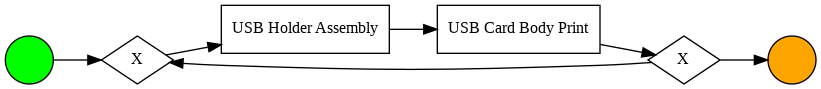

bpmn to gviz
Saving a bpmn as png
Saving a bpmn
../datasets/MF-connect.csv is valid for evaluation


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

../datasets/MF-connect.csv is valid for evaluation
View a bpmn


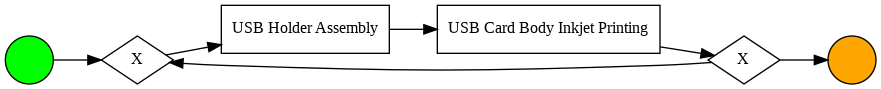

bpmn to gviz
Saving a bpmn as png
Saving a bpmn


In [8]:
def save_bpmn(dataset, key_indices=None, attribute=''):
    # extract the dataset name
    dataset_name = re.match('../datasets/(.+).csv', dataset).groups()[0]
    # read the event log
    event_log = load_event_log(dataset, n_rows=1000)
    # when colnames are given, we set it the dataset's header
    if key_indices is not None:
        event_log = event_log.iloc[:, key_indices]
        event_log.columns = ['case:concept:name', 'time:timestamp', 'concept:name']
    # discover a process model
    try:
        net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
        # convert it from petri nets to a process tree
        pt = pm4py.convert.convert_to_process_tree(net, initial_marking, final_marking)
        # convert the process tree to a bpmn
        bpmn = pm4py.convert.convert_to_bpmn(pt)
    except:
        print('Something wrong happened in converting to BPMN.')
    try:
        # save it
        print('View a bpmn')
        pm4py.vis.view_bpmn(bpmn)
    except:
        print('Something wrong happened in trying to view a bpmn')
    print('bpmn to gviz')
    # pm4py.vis.save_vis_petri_net(net, initial_marking, final_marking, '../plots/', dataset_name + '_pn.png')
    gviz = pm4py.visualization.bpmn.visualizer.apply(bpmn)
    try:
        print('Saving a bpmn as png')
        pm4py.visualization.bpmn.visualizer.save(gviz, '../plots/' + dataset_name + attribute + '_bpmn.png')
    except:
        print('Something wrong happened in trying to save a bpmn as png')
    try:
        print('Saving a bpmn')
        pm4py.write.write_bpmn(bpmn, '../plots/' + dataset_name + attribute + '.bpmn')
    except:
        print('Something wrong happened.')

# datasets = glob.glob('../datasets/*.csv', recursive=False)
# [save_bpmn(d) for d in datasets]
dataset = '../datasets/MF-connect.csv'
# save the manual one
save_bpmn(dataset)
# save the model discovered by our method
event_log = load_event_log(dataset, n_rows=1000)
display(colnames)
save_bpmn(dataset, key_indices=[0, 14, 2], attribute='_our_method_0_14_2')